# Maskify the target
*2019-11-15*

*Goal:* The goal of this notebook is to turn the target into a proper mask.

## Imports and Utils

In [1]:
from itertools import chain
from collections import Counter
from functools import partial

from pathlib import Path
Path.ls = property(lambda path: sorted(list(path.iterdir())))

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pelper import pipe

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import functional as TF

from wssseg.torch_utils import DEVICE, imagenet_stats

%matplotlib inline

In [2]:
# Taken https://github.com/pytorch/vision/tree/master/references/segmentation
from typing import Callable
from wssseg.torchseg import transforms as T

def get_transform(train: bool) -> Callable:
    base_size = 520
    crop_size = 480

    transforms = []

    min_size = int((0.5 if train else 1.0) * base_size)
    max_size = int((2.0 if train else 1.0) * base_size)
    transforms.append(T.RandomResize(min_size, max_size))
    
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
        transforms.append(T.RandomCrop(crop_size))
    
    transforms.append(T.ToTensor())
    transforms.append(T.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225]))

    return T.Compose(transforms)

trfm = get_transform(False)

# Analysis

## Dataset
A dummy dataset class to ease working with the data.
Maybe we have to adjust it later.

In [3]:
from torchvision.datasets import VisionDataset
from typing import Sequence, List

In [4]:
masks = Path("../data/raw/ground_truth/").ls
images = Path("../data/raw/top/").ls

In [5]:
class VaihingenSegmentationDataset(VisionDataset):
    def __init__(self, images: Sequence, masks: Sequence, transforms=None):
        assert len(images) == len(masks)
        assert set([p.name.split("_")[-1] for p in images]) == set([p.name.split("_")[-1] for p in masks])
        
        super().__init__(root=None, transforms=transforms)
        self.images = images
        self.masks = masks
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("RGB")
        target = Image.open(self.masks[index])

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

A nice little plot function

In [6]:
def show_sample(ds, idx, size=500, figsize=(20, 6)):
    size = size, size
    img = Image.open(ds.images[idx]).resize(size)
    mask = Image.open(ds.masks[idx]).resize(size)
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    axes[0].imshow(img)
    axes[1].imshow(mask)
    axes[2].imshow(img)
    axes[2].imshow(mask, alpha=0.3)
    
    fig.suptitle(f"Sample: {idx}")
    for ax in axes:
        ax.axis("off")

        
VaihingenSegmentationDataset.show_sample = show_sample
ds = VaihingenSegmentationDataset(images, masks)
ds.show_sample(14)

## To Mask
The current mask is not in the format that we want.
We have to transform it.

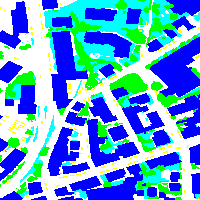

In [7]:
ds[0][1].resize((200, 200))

Here are the object classes, their color, and id

In [8]:
OBJECTS = [
    ("impervious", (1, 1, 1), 0),      # WHITE
    ("building", (0, 0, 1),  1),       # BLUE
    ("low_vegetation", (0, 1, 1), 2),  # TURQUOISE
    ("tree", (0, 1, 0), 3),            # GREEN
    ("car", (1, 1, 0), 4),             # YELLOW
    ("clutter", (1, 0, 0), 255),       # RED
]
assert len(OBJECTS) == 6

Let's get a sample from the dataset.

In [9]:
img, mask = ds[0]
img, mask = TF.to_tensor(img), TF.to_tensor(mask)
img.shape, mask.shape

(torch.Size([3, 2569, 1919]), torch.Size([3, 2569, 1919]))

Now we can select part of the mask by color:

(3, 2569, 1919)
(2569, 1919)


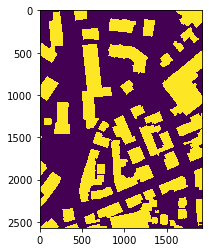

In [10]:
np_mask = mask.numpy()
print(np_mask.shape)

ID = 1
color = np.array(OBJECTS[ID][1])[:, None, None]
tmp = np.all(np_mask == color, axis=0)
print(tmp.shape)

plt.imshow(tmp);

Plot all layers

0 1753163
1 1852765
2 621535
3 626123
4 76323
255 2


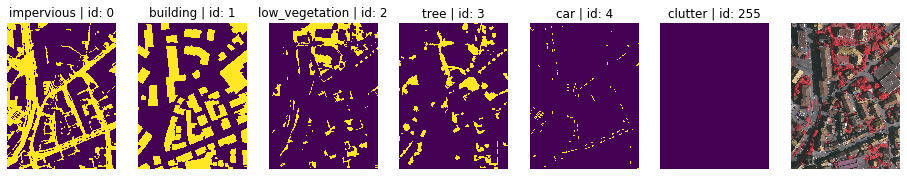

In [11]:
fig, axes = plt.subplots(1, 7, figsize=(16, 3))

for (obj_name, color, i), ax in zip(OBJECTS, axes):
    color = np.array(color)[:, None, None]
    tmp = np.all(np_mask == color, axis=0)
    print(i, tmp.sum())
    
    ax.imshow(tmp)
    ax.axis("off")
    ax.set_title(f"{obj_name} | id: {i}")
    
axes[-1].imshow(img.permute(1, 2, 0))
axes[-1].axis("off");

In [12]:
# Alternative way to convert the mask.
# Faster but less flexible
#
# mask = np.array(Image.open(masks[0]).convert("L"))
# obj_ids = np.unique(mask)
# _masks = mask == obj_ids[:, None, None]
# print(_masks.shape)
# torch.as_tensor(_masks, dtype=torch.uint8)[:, 4, 4]

Extract the functionality into a helper function:

0 1753163
1 1852765
2 621535
3 626123
4 76323
255 2
torch.Size([2569, 1919])


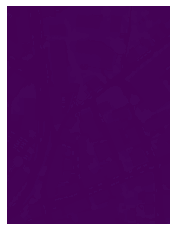

In [13]:
def maskify(img_mask: torch.Tensor) -> torch.Tensor:
    OBJECTS = [
        ("impervious", (1, 1, 1), 0),      # WHITE
        ("building", (0, 0, 1),  1),       # BLUE
        ("low_vegetation", (0, 1, 1), 2),  # TURQUOISE
        ("tree", (0, 1, 0), 3),            # GREEN
        ("car", (1, 1, 0), 4),             # YELLOW
        ("clutter", (1, 0, 0), 255),       # RED
        # ("clutter", (1, 0, 0), 5),       # RED
    ]
    
    np_mask = img_mask.numpy()
    result_mask = np.zeros(np_mask.shape[1:], dtype=np.uint8)
    for (obj_name, color, id_) in OBJECTS:
        color = np.array(color)[:, None, None]
        obj_mask = np.all(np_mask == color, axis=0)
        result_mask[obj_mask] = id_
        print(id_, obj_mask.sum())
    return torch.from_numpy(result_mask)


mask = TF.to_tensor(ds[0][1])

tmp = maskify(mask)
print(tmp.shape)

# Note that we can't see the mask because 255 is an outlier compared to the rest
fig, ax = plt.subplots()
ax.imshow(tmp)
ax.axis("off");

In [14]:
print(tmp.shape)
original_counter = dict(
    {
        k.item(): count.item()
        for (k, count) in zip(*tmp.unique(return_counts=True))
    }
)
original_counter

torch.Size([2569, 1919])


{0: 1753163, 1: 1852765, 2: 621535, 3: 626123, 4: 76323, 255: 2}

In [15]:
TF.to_pil_image(tmp).save("/tmp/mask_stnisnt.tif")

In [16]:
mask_loaded = pipe(
    "/tmp/mask_stnisnt.tif",
    Image.open,
    np.asarray,
    partial(torch.as_tensor, dtype=torch.int64),
)

Make sure it's the loaded mask is the same as before

In [17]:
print(tmp.shape)
for i, c in zip(*mask_loaded.unique(return_counts=True)):
    assert original_counter[i.item()] == c.item()

torch.Size([2569, 1919])


In [18]:
assert (mask_loaded == tmp).all()

## Convert all masks


In [19]:
dst_dir = Path("/tmp/data/raw/masks")
dst_dir.mkdir(parents=True, exist_ok=True)
for src in masks:
    dst = dst_dir / src.name
    print(src, "-->", dst)

    pipe(
        str(src),
        Image.open,
        TF.to_tensor,
        maskify,
        TF.to_pil_image,
        lambda img: img.save(dst)
    )
        
    break

../data/raw/ground_truth/top_mosaic_09cm_area1.tif --> /tmp/data/raw/masks/top_mosaic_09cm_area1.tif
0 1753163
1 1852765
2 621535
3 626123
4 76323
255 2


This seems to work.
See `wsseg/cli/preprocess.py` for the actual implementation.